In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
features = [
#     'clean_q1_tokenized',
#     'clean_q2_tokenized',
#     'clean_q1_stem',
#     'clean_q2_stem',
#     'clean_q1_pos_tagged',
#     'clean_q2_pos_tagged',
    'clean_q1_lemmatized',
    'clean_q2_lemmatized',
#     'clean_q1_lemmatized_stem',
#     'clean_q2_lemmatized_stem'
]

In [4]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

In [5]:
train = read_data('train', features)#[:1000]
test = read_data('test', features)#[:1000]

In [6]:
words = train.clean_q1_lemmatized.tolist() + train.clean_q2_lemmatized.tolist() + test.clean_q1_lemmatized.tolist() + test.clean_q2_lemmatized.tolist()

uniq_words = set(' '.join(word) for word in words)
len(uniq_words)

4767235

In [7]:
from nltk import FreqDist
words = []
for s in uniq_words:
    words.extend(set(s.lower().split()))
freq = FreqDist(words)

In [8]:
def get_weight(word):
    return 1 - freq[word] / len(uniq_words)

In [9]:
def max_sims(q1_words, q2_words):
    q2_words = [w for w in q2_words if w in model]

    sim = {}
    for q1_word in q1_words:
        if q1_word in model:
            sim[q1_word] = max((model.similarity(q1_word, q2_word) for q2_word in q2_words), default=0)
        else:
            sim[q1_word] = -1
    return sim

thresholds = [
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
]
def sum_weight_common_words_with_word2vec_threshold(row):
    q1_words = set(word for word in row.clean_q1_lemmatized if word not in stops)
    q2_words = set(word for word in row.clean_q2_lemmatized if word not in stops)
    common_words = q1_words & q2_words
    uncommon_q1_words = q1_words - common_words
    uncommon_q2_words = q2_words - common_words
    
    q1_sims = max_sims(uncommon_q1_words, q2_words)
    q2_sims = max_sims(uncommon_q2_words, q1_words)
    
    result = {}
    sum_common_base = sum(get_weight(word) for word in common_words)
    for thresh in thresholds:
        sum_common = sum_common_base
        sum_uncommon = 0

        for word, sim in q1_sims.items():
            if sim >= thresh:
                sum_common += get_weight(word)
            else:
                sum_uncommon += get_weight(word)

        for word, sim in q2_sims.items():
            if sim >= thresh:
                sum_common += get_weight(word)
            else:
                sum_uncommon += get_weight(word)
        
        result['sum_prob_weight_common_words_thresh_{:.2f}'.format(thresh)] = sum_common
        result['sum_prob_weight_uncommon_words_thresh_{:.2f}'.format(thresh)] = sum_uncommon

    return pd.Series(result)

In [10]:
train_features = train.apply(sum_weight_common_words_with_word2vec_threshold, axis=1)

In [11]:
train = pd.merge(train, train_features, left_index=True, right_index=True)

In [12]:
test_features = test.apply(sum_weight_common_words_with_word2vec_threshold, axis=1)

In [13]:
test = pd.merge(test, test_features, left_index=True, right_index=True)

In [14]:
features_to_save = list(train_features)

In [15]:
features_to_save

['sum_prob_weight_common_words_thresh_0.20',
 'sum_prob_weight_common_words_thresh_0.30',
 'sum_prob_weight_common_words_thresh_0.40',
 'sum_prob_weight_common_words_thresh_0.50',
 'sum_prob_weight_common_words_thresh_0.60',
 'sum_prob_weight_common_words_thresh_0.70',
 'sum_prob_weight_common_words_thresh_0.80',
 'sum_prob_weight_common_words_thresh_0.90',
 'sum_prob_weight_common_words_thresh_0.95',
 'sum_prob_weight_uncommon_words_thresh_0.20',
 'sum_prob_weight_uncommon_words_thresh_0.30',
 'sum_prob_weight_uncommon_words_thresh_0.40',
 'sum_prob_weight_uncommon_words_thresh_0.50',
 'sum_prob_weight_uncommon_words_thresh_0.60',
 'sum_prob_weight_uncommon_words_thresh_0.70',
 'sum_prob_weight_uncommon_words_thresh_0.80',
 'sum_prob_weight_uncommon_words_thresh_0.90',
 'sum_prob_weight_uncommon_words_thresh_0.95']

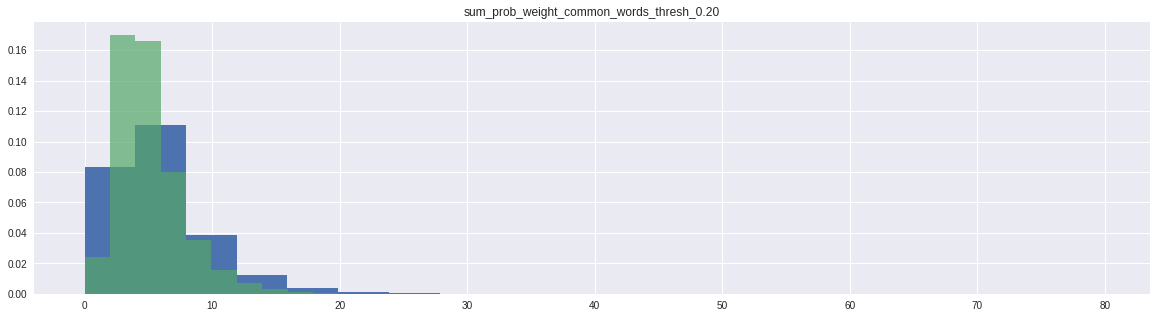

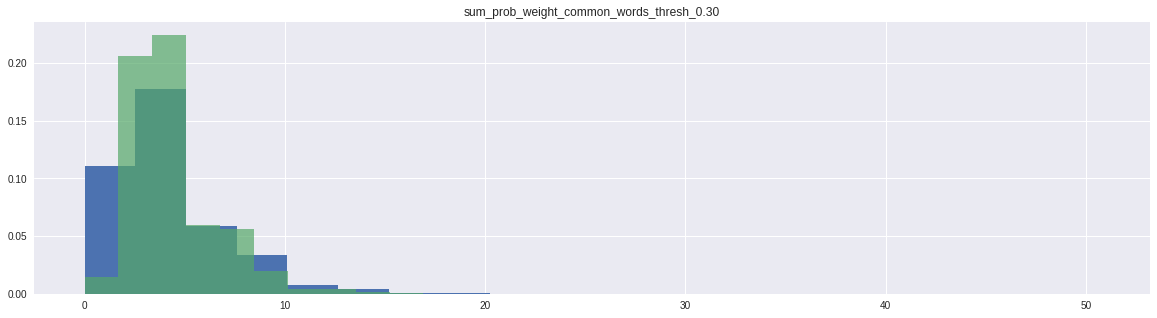

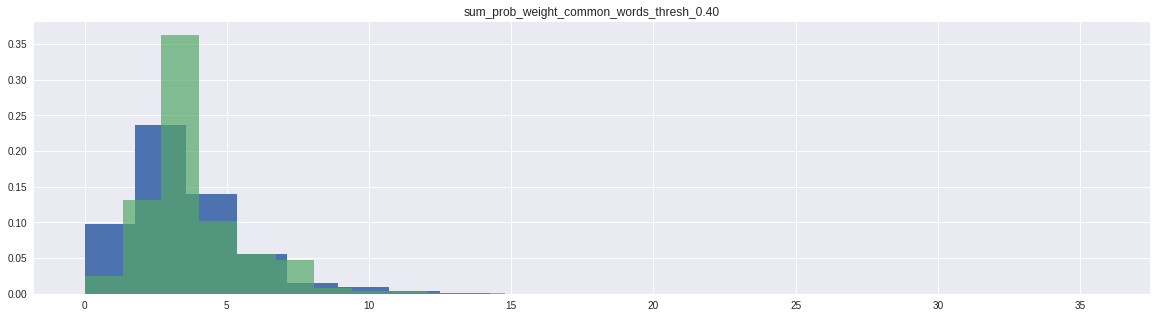

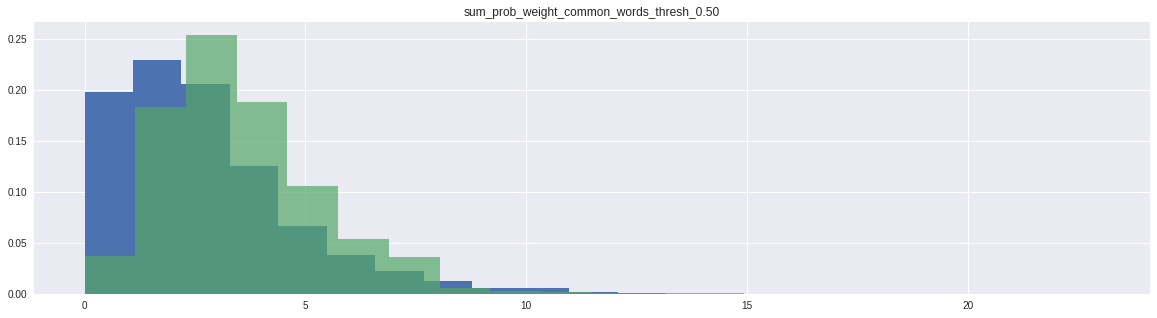

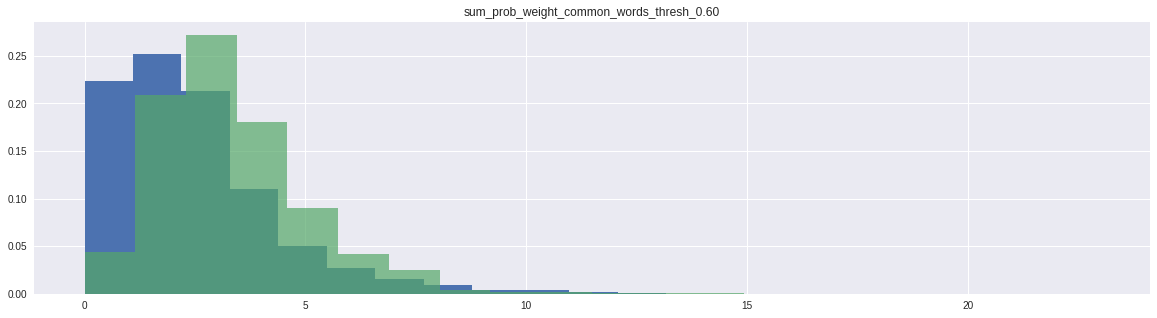

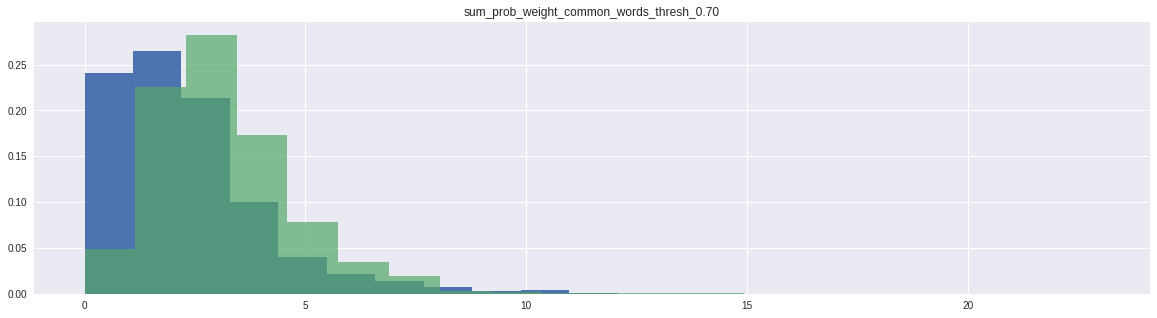

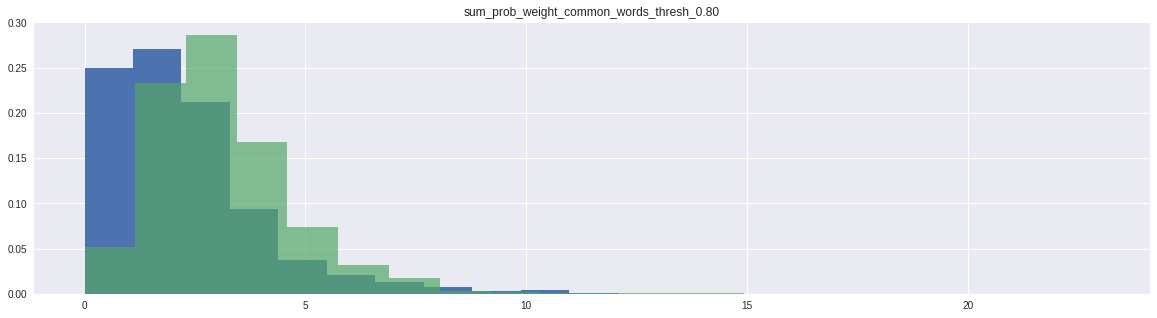

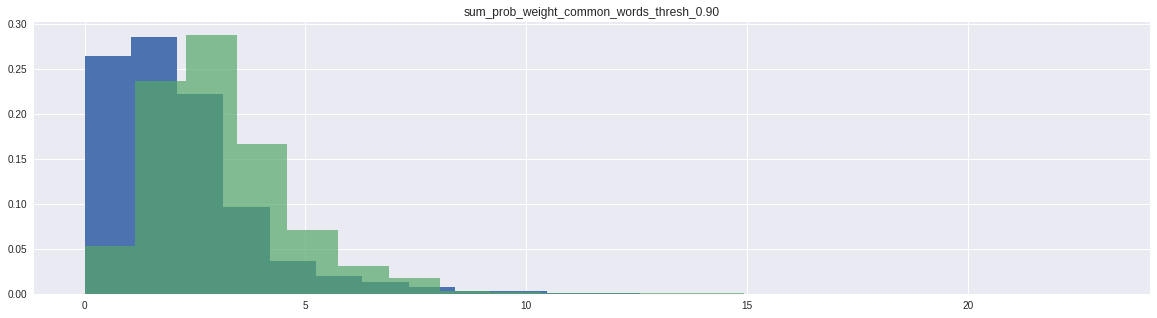

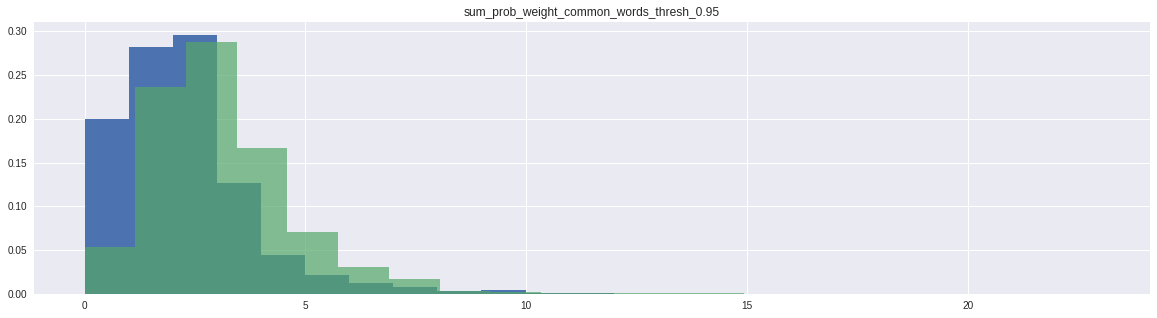

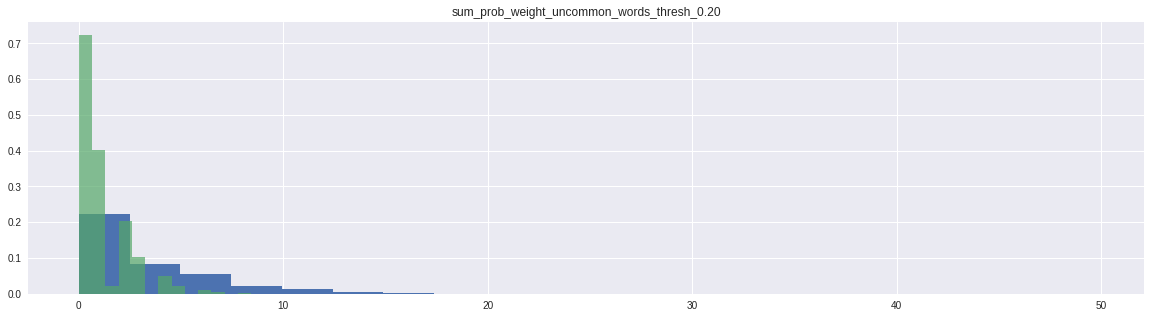

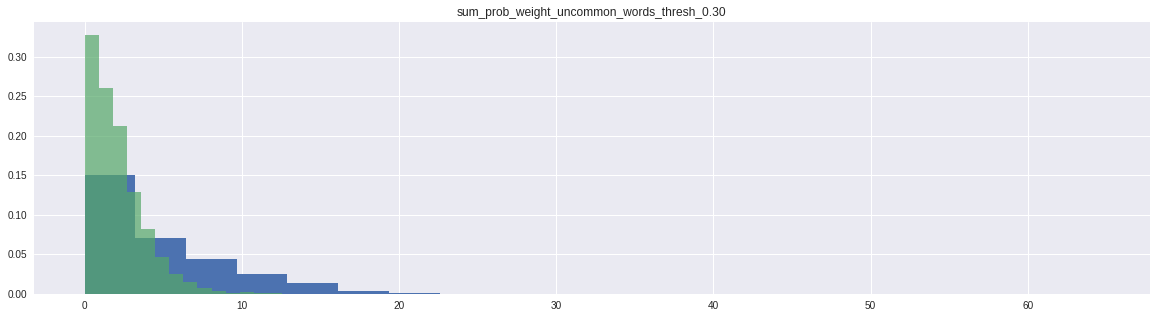

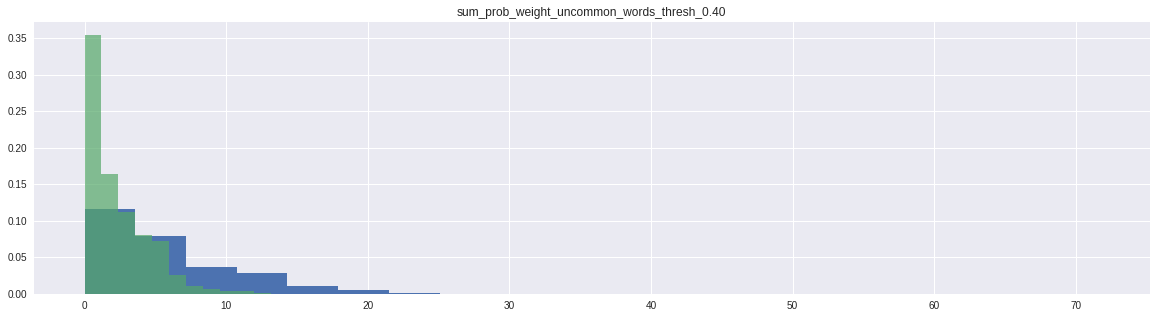

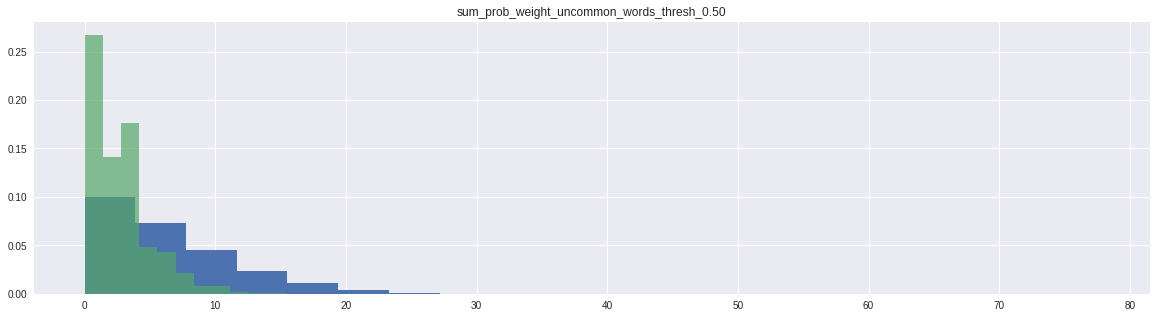

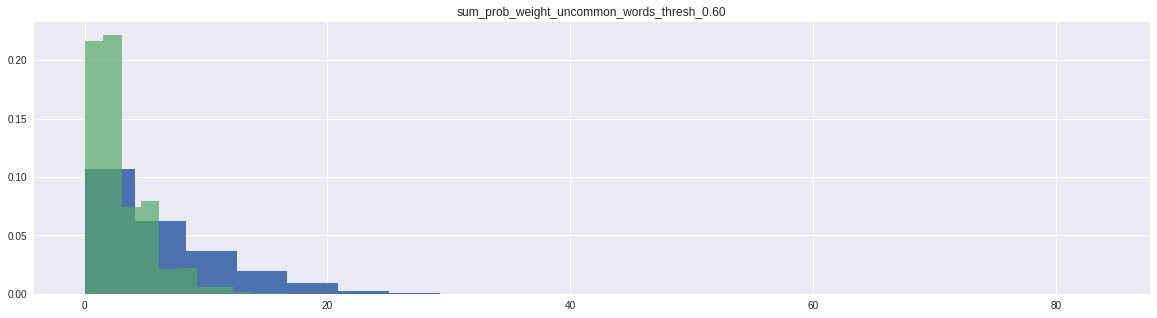

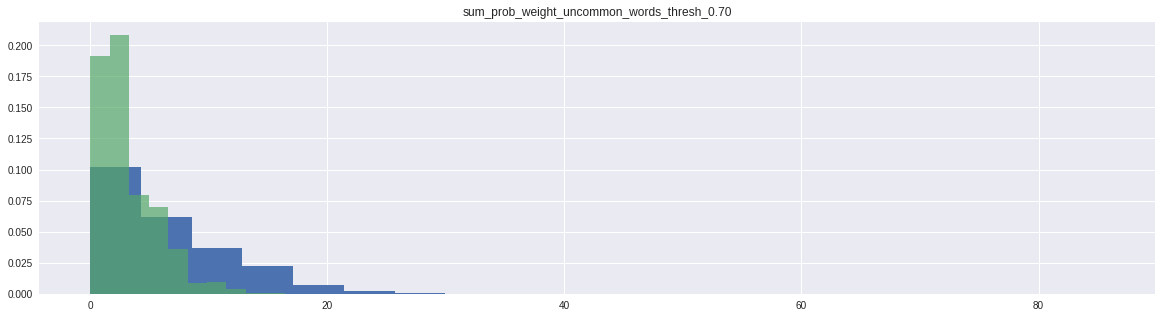

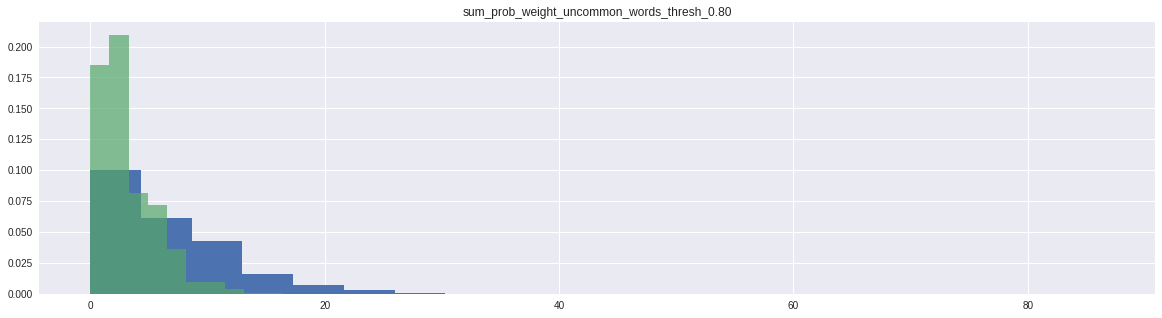

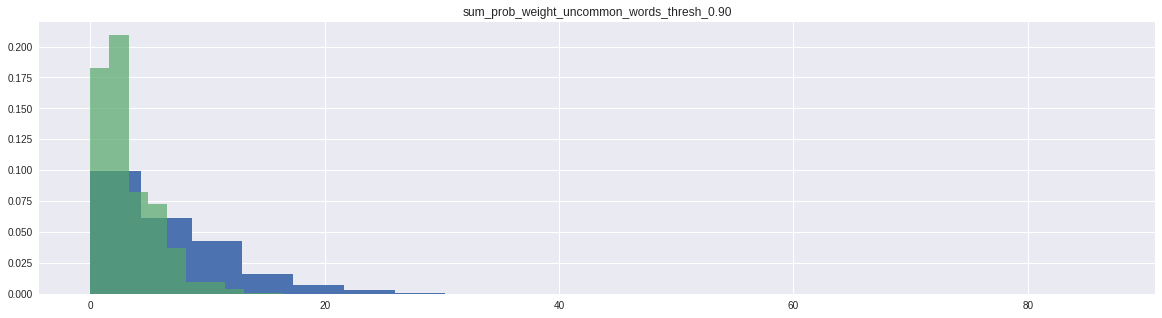

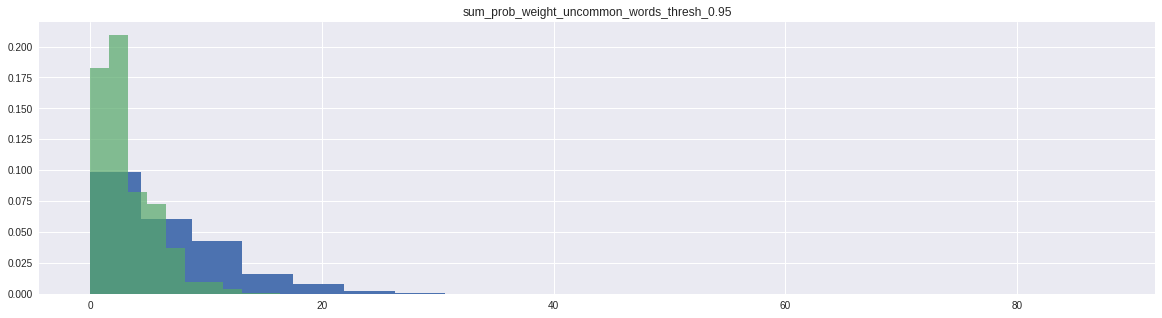

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 5.0)

for feature in features_to_save:
    plt.title(feature)
    plt.hist(train[feature][train['is_duplicate'] == 0], bins=20, normed=True, label='0')
    plt.hist(train[feature][train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
    plt.show()

In [17]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')